# Pipeline for the anomaly detection on the SKAB using Feed Forward Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [1]:
# libraries importing
import sys
import warnings

import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.Vanilla_AE import Vanilla_AE
from core.metrics import chp_score
from core.utils import load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

2024-04-29 19:04:05.399512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [2]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [3]:
# hyperparameters selection
BEST_PARAMS = [5, 4, 2, 0.005, 32]
Q = 0.99  # quantile for upper control limit (UCL) selection

In [4]:
# model defining
model = Vanilla_AE(BEST_PARAMS)

### Method fitting and applying

In [5]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # model fitting
    model.fit(StSc.transform(X_train))

    # results predicting
    residuals_train = (
        pd.DataFrame(
            StSc.transform(X_train) - model.predict(StSc.transform(X_train))
        )
        .abs()
        .sum(axis=1)
    )
    UCL = residuals_train.quantile(Q) * 5 / 2

    df_sc = StSc.transform(X_test)
    residuals_full_df = df_sc - model.predict(df_sc)
    residuals_full_df = pd.DataFrame(residuals_full_df).abs().sum(axis=1)

    prediction = pd.Series(
        (residuals_full_df > UCL).astype(int).values, index=X_test.index
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━

### Results visualization

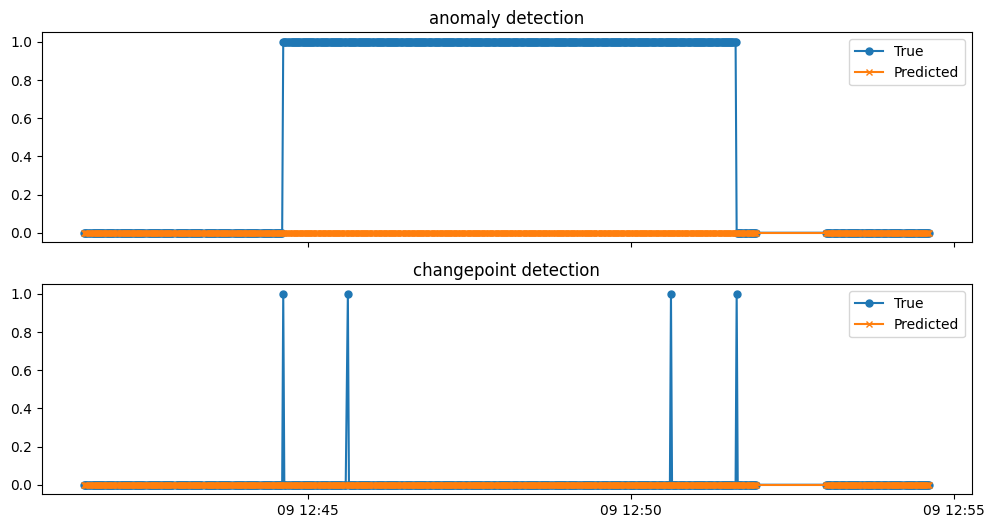

In [6]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [7]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 2.59 %
Missing Alarm Rate 75.15 %
F1 metric 0.39


### Changepoint detection metrics

In [8]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 127
A number of missed CPs = 101
A number of FPs = 64
Average time 0 days 00:00:29.361538461


In [10]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="righter",
)

Standard  -  5.95
LowFP  -  -0.91
LowFN  -  8.69
